In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score

In [11]:
batchsize = 100
lr=0.1
momentum=0.9
weight_decay=1e-4
num_epoch=50

100%|███████████████████████████████████████████████████████████████| 169001437/169001437 [01:01<00:00, 2748530.51it/s]


Extracting data\cifar-100-python.tar.gz to data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

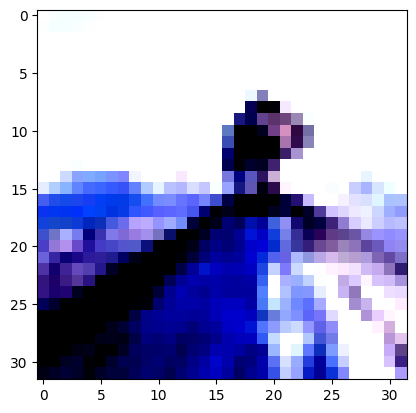

In [3]:
cifar100_train = datasets.CIFAR100(root = "data", 
                                   train = True, 
                                   download = True, 
                                   transform = transforms.Compose([
                                       ToTensor(), 
                                       #transforms.ConvertImageDtype(torch.float), 
                                       transforms.Normalize(
                                           mean = np.array([0.5070751592371323, 0.48654887331495095, 0.4409178433670343]), 
                                           std = np.array([0.2673342858792401, 0.2564384629170883, 0.27615047132568404]))]))
cifar100_test = datasets.CIFAR100(root = "data", 
                                  train = False, 
                                  download = True, 
                                  transform = transforms.Compose([
                                      ToTensor(), 
                                      #transforms.ConvertImageDtype(torch.float), 
                                      transforms.Normalize(
                                           mean = np.array([0.5070751592371323, 0.48654887331495095, 0.4409178433670343]), 
                                           std = np.array([0.2673342858792401, 0.2564384629170883, 0.27615047132568404]))]))

data_loader_train = torch.utils.data.DataLoader(cifar100_train,
                                                batch_size=batchsize,
                                                shuffle=True)
data_loader_test = torch.utils.data.DataLoader(cifar100_test,
                                                batch_size=batchsize,
                                                shuffle=True)

print(cifar100_test.classes)
plt.imshow(cifar100_test[0][0].permute(1,2,0))

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
!nvidia-smi

Using cuda device
Fri Mar  1 14:11:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.26                 Driver Version: 546.26       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   48C    P0              23W / 135W |    769MiB /  8188MiB |     10%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+-------

In [5]:
def text_save(filename, data1):#filename为写入CSV文件的路径，data为要写入数据列表.
    file = open(filename,'a')
    for i in range(len(data1)):
        s1 = str(data1[i]).replace('[','').replace(']','')#去除[],这两行按数据不同，可以选择
        s1 = s1.replace("'",'').replace(',','') +'\n' #去除单引号，逗号，每行末尾追加换行符
        file.write(s1)
#    for i in range(len(data2)):
#        s2 = str(data2[i]).replace('[','').replace(']','')#去除[],这两行按数据不同，可以选择
#        s2 = s2.replace("'",'').replace(',','') +'\n' #去除单引号，逗号，每行末尾追加换行符
#        file.write(s2)
    file.close()
    print("保存成功")

In [6]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x): 
        out = self.conv1(x)
        nn.Dropout(0.4)
        out = F.relu(self.bn1(out))
        out = self.conv2(out)
        nn.Dropout(0.4)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        nn.Dropout(0.4)
        out = F.relu(self.bn1(out))
        out = self.conv2(out)
        nn.Dropout(0.4)
        out = F.relu(self.bn2(out))
        out = self.conv3(out)
        nn.Dropout(0.4)
        out = self.bn3(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
#        print(out.shape)
        out = self.layer1(out)
#        print(out.shape)
        out = self.layer2(out)
#        print(out.shape)
        out = self.layer3(out)
#        print(out.shape)
        out = self.layer4(out)
#        print(out.shape)
        out = F.avg_pool2d(out, 4)
#        print(out.shape)
        out = out.view(out.size(0), -1)
#        print(out.shape)
        out = self.linear(out)
#        print(out.shape)
        return out

def ResNet6():
    return ResNet(BasicBlock, [1, 1, 0, 0])

    
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

# test()

In [7]:
class FKernelforResNet18():
    def __init__(self):
        self.basic_weight = [[0, 0, 0], [0, 1, 0], [0, 0, 0]]
        
        self.g_tensor_3 = [[self.basic_weight for p in range(3)] for q in range(64)]
        self.g_tensor_3 = torch.tensor(self.g_tensor_3, dtype=torch.float)
        #print(self.g_tensor_3)

        self.g_tensor_64 = [[self.basic_weight for p in range(64)] for q in range(64)]
        self.g_tensor_64 = torch.tensor(self.g_tensor_64, dtype=torch.float)
        
        self.g_tensor_64_ = [[self.basic_weight for p in range(64)] for q in range(128)]
        self.g_tensor_64_ = torch.tensor(self.g_tensor_64_, dtype=torch.float)

        self.g_tensor_128 = [[self.basic_weight for p in range(128)] for q in range(128)]
        self.g_tensor_128 = torch.tensor(self.g_tensor_128, dtype=torch.float)
        
        self.g_tensor_128_ = [[self.basic_weight for p in range(128)] for q in range(256)]
        self.g_tensor_128_ = torch.tensor(self.g_tensor_128_, dtype=torch.float)

        self.g_tensor_256 = [[self.basic_weight for p in range(256)] for q in range(256)]
        self.g_tensor_256 = torch.tensor(self.g_tensor_256, dtype=torch.float)
        
        self.g_tensor_256_ = [[self.basic_weight for p in range(256)] for q in range(512)]
        self.g_tensor_256_ = torch.tensor(self.g_tensor_256_, dtype=torch.float)

        self.g_tensor_512 = [[self.basic_weight for p in range(512)] for q in range(512)]
        self.g_tensor_512 = torch.tensor(self.g_tensor_512, dtype=torch.float)

    def forward(self, net, device):
        custom_loss = 0
        num_conv = -1

        for param in net.parameters():
            num_conv = num_conv + 1
            
            param_ = param.to("cpu")
            if num_conv == 0:
                #print(param_[15])
                modify = param_ - self.g_tensor_3
            if num_conv == 3 or num_conv == 6 or num_conv == 9 or num_conv == 12:
                modify = param_ - self.g_tensor_64
            if num_conv == 15:
                modify = param_ - self.g_tensor_64_
            if num_conv == 18 or num_conv == 24 or num_conv == 27:
                modify = param_ - self.g_tensor_128
            if num_conv == 30:
                modify = param_ - self.g_tensor_128_
            if num_conv == 33 or num_conv == 39 or num_conv == 42:
                modify = param_ - self.g_tensor_256
            if num_conv == 45:
                modify = param_ - self.g_tensor_256_
            if num_conv == 48 or num_conv == 54 or num_conv == 57:
#              print(param_)
                modify = param_ - self.g_tensor_512
              
#              print(modify)
#                target_weight = g_tensor
#                target_weight = target_weight.to(device)
#            print(num_conv, param.shape)
#            custom_loss = 1
#                modify = param_ - g_tensor
#                print(modify)
            custom_loss += torch.sum(torch.norm(modify, p = 2).pow(2))
#                print(custom_loss)
        return custom_loss

In [47]:
class FKernelforResNet50():
    def __init__(self):
        basic_weight = [[0, 0, 0], [0, 1, 0], [0, 0, 0]]

        self.g_tensor_3 = [[basic_weight for p in range(3)] for q in range(64)]
        self.g_tensor_3 = torch.tensor(self.g_tensor_3, dtype=torch.float)

        self.g_tensor_64 = [[basic_weight for p in range(64)] for q in range(64)]
        self.g_tensor_64 = torch.tensor(self.g_tensor_64, dtype=torch.float)

        self.g_tensor_128 = [[basic_weight for p in range(128)] for q in range(128)]
        self.g_tensor_128 = torch.tensor(self.g_tensor_128, dtype=torch.float)

        self.g_tensor_256 = [[basic_weight for p in range(256)] for q in range(256)]
        self.g_tensor_256 = torch.tensor(self.g_tensor_256, dtype=torch.float)

        self.g_tensor_512 = [[basic_weight for p in range(512)] for q in range(512)]
        self.g_tensor_512 = torch.tensor(self.g_tensor_512, dtype=torch.float) 

    def forward(self, net, device):
        num_conv = -1
        custom_loss = 0
        
        for param in net.parameters():
            num_conv = num_conv + 1
            
            param_ = param.to("cpu")
            if num_conv == 0:
                modify = param_ - self.g_tensor_3
            if num_conv == 6 or num_conv == 18 or num_conv == 27:
                modify = param_ - self.g_tensor_64
            if num_conv == 36 or num_conv == 48 or num_conv == 57 or num_conv == 66:
                modify = param_ - self.g_tensor_128
            if num_conv == 75 or num_conv == 87 or num_conv == 96 or num_conv == 105 or num_conv == 114 or num_conv == 123:
                modify = param_ - self.g_tensor_256
            if num_conv == 132 or num_conv == 144 or num_conv == 153:
#              print(param_)
                modify = param_ - self.g_tensor_512
              
#                print(modify)
#                target_weight = g_tensor
#                target_weight = target_weight.to(device)
#            print(num_conv, param.shape)
#            custom_loss = 1
#                modify = param_ - g_tensor
#                print(modify)
            custom_loss += torch.sum(torch.norm(modify, p = 2).pow(2))
#                print(custom_loss)
        return custom_loss

In [15]:
#np.random.seed(100)
#torch.manual_seed(100)
#torch.cuda.manual_seed_all(100)
#random.seed(100)
#torch.backends.cudnn.benchmark = False
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.enabled = True

net = ResNet18()
#net.load_state_dict(torch.load(PATH))
#net.eval()
#checkpoint = torch.load("49D.ckpt")
#net.load_state_dict(checkpoint['model_state_dict'])
#epoch = checkpoint['epoch']
#loss = checkpoint['loss']
net.eval()
net = net.to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=momentum, weight_decay=weight_decay, nesterov=True)
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


train_acc = []
valid_acc = []
train_loss_array = []
valid_loss_array = []
custom_loss_array = []
criterion = nn.CrossEntropyLoss()
#lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr,steps_per_epoch=len(data_loader_train),
#                                                   epochs=num_epoch,div_factor=div_factor,final_div_factor=final_div,pct_start=pct_start)

#target_weight = torch.tensor(0)
#target_weight = target_weight.to(device)
FKernelforResNet18_ = FKernelforResNet18()

def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    train_classify_loss = 0
    train_custom_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(data_loader_train):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        classify_loss = criterion(outputs, targets)
        custom_loss = FKernelforResNet18_.forward(net,device)
        train_classify_loss += classify_loss.item()
        train_custom_loss += 0.0000001 * custom_loss.item()#0.0000001
#        print(train_classify_loss/(batch_idx+1), '|', train_custom_loss/(batch_idx+1))
#        if custom_loss < 10000:
#            mode = 1
#        if mode == 0:
        loss = classify_loss + 0.0000001 * custom_loss
#        else:
#        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
#        lr_scheduler.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

#        print(batch_idx, '|', len(data_loader_train), '|', train_loss/(batch_idx+1), '|', 100.*correct/total)
#        progress_bar(batch_idx, len(data_loader_train), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
#                     % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    train_acc.append(correct/total)
    train_loss_array.append(train_loss/len(data_loader_train))
    custom_loss_array.append(train_custom_loss/len(data_loader_train))
    model_state_path = str(epoch) + "D.ckpt"
    torch.save({
       'epoch': epoch,
       'model_state_dict': net.state_dict(),
       'optimizer_state_dict': optimizer.state_dict(),
       'loss': loss,
      }, model_state_path)

def test(epoch):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(data_loader_test):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        print(batch_idx, '|', len(data_loader_test), '|', test_loss/(batch_idx+1), '|', 100.*correct/total)
#        progress_bar(batch_idx, len(data_loader_test), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
#                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    valid_acc.append(correct/total)
    valid_loss_array.append(test_loss/len(data_loader_test))
    
for epoch in range(num_epoch):
    train(epoch)
    test(epoch)

print("Best test accuracy: {}".format(max(valid_acc)))
#torch.save(net.state_dict(), "40D.pth")
text_save("dataDtrain_acc.txt", train_acc)
text_save("dataDvalid_acc.txt", valid_acc)
text_save("dataDtrainloss.txt", train_loss_array)
text_save("dataDvalidloss.txt", valid_loss_array)
text_save("dataDcustomloss.txt", custom_loss_array)


Epoch: 0
156 | 157 | 3.3044893696049975 | 20.28

Epoch: 1
156 | 157 | 2.7679800303878297 | 30.61

Epoch: 2
156 | 157 | 2.508661550321397 | 35.5

Epoch: 3
156 | 157 | 2.238823525465218 | 40.38

Epoch: 4
156 | 157 | 2.1478694821618927 | 42.8

Epoch: 5
156 | 157 | 2.0910018515434996 | 45.0

Epoch: 6
156 | 157 | 2.160255268880516 | 44.56

Epoch: 7
156 | 157 | 2.0724652504465384 | 46.47

Epoch: 8
156 | 157 | 2.103508583299673 | 46.8

Epoch: 9
156 | 157 | 2.180141506681017 | 46.3

Epoch: 10
156 | 157 | 2.2073996795970166 | 47.07

Epoch: 11
156 | 157 | 2.160799380320652 | 48.76

Epoch: 12
156 | 157 | 2.0888053809001947 | 50.38

Epoch: 13
156 | 157 | 2.099815367893049 | 50.78

Epoch: 14
156 | 157 | 2.106444922981748 | 50.47

Epoch: 15
156 | 157 | 2.1256386466846346 | 50.89

Epoch: 16
156 | 157 | 2.121566792202603 | 51.14

Epoch: 17
156 | 157 | 2.1298809605798903 | 50.76

Epoch: 18
156 | 157 | 2.143908026871408 | 50.87

Epoch: 19
156 | 157 | 2.1588540525193425 | 50.59

Epoch: 20
156 | 157 | 2.

In [33]:
net = ResNet18()
FKernelforResNet18_ = FKernelforResNet18()
custom_loss = FKernelforResNet18_.forward(net,device)

tensor([[[[0., 0., 0.],
          [0., 1., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 1., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 1., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 0.],
          [0., 1., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 1., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 1., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 0.],
          [0., 1., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 1., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 1., 0.],
          [0., 0., 0.]]],


        ...,


        [[[0., 0., 0.],
          [0., 1., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 1., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 1., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 0.],
          [0., 1., 0.],
          [0., 0., 0.]],

         [[0., 

In [31]:
net = ResNet18()
checkpoint = torch.load("59D.ckpt")
net.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
net.eval()
net = net.to(device)
FKernelforResNet18_ = FKernelforResNet18()
custom_loss = FKernelforResNet18_.forward(net,device)

tensor([[[ 0.1405,  0.0757,  0.0691],
         [ 0.0184, -0.1227, -0.0362],
         [ 0.0121, -0.0466, -0.1004]],

        [[ 0.0307,  0.0241,  0.0616],
         [-0.0855, -0.0692,  0.0639],
         [-0.0025, -0.0095, -0.0176]],

        [[-0.0880, -0.0636, -0.0171],
         [-0.0984, -0.0636,  0.0507],
         [ 0.0712,  0.1174,  0.0787]]], grad_fn=<SelectBackward0>)


score_array: (10000, 100)
label_onehot: (10000, 100)


C:\Users\10252\AppData\Local\Temp\ipykernel_7800\1548909721.py:71: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr_dict[i], tpr_dict[i])


micro
macro
0
1
2


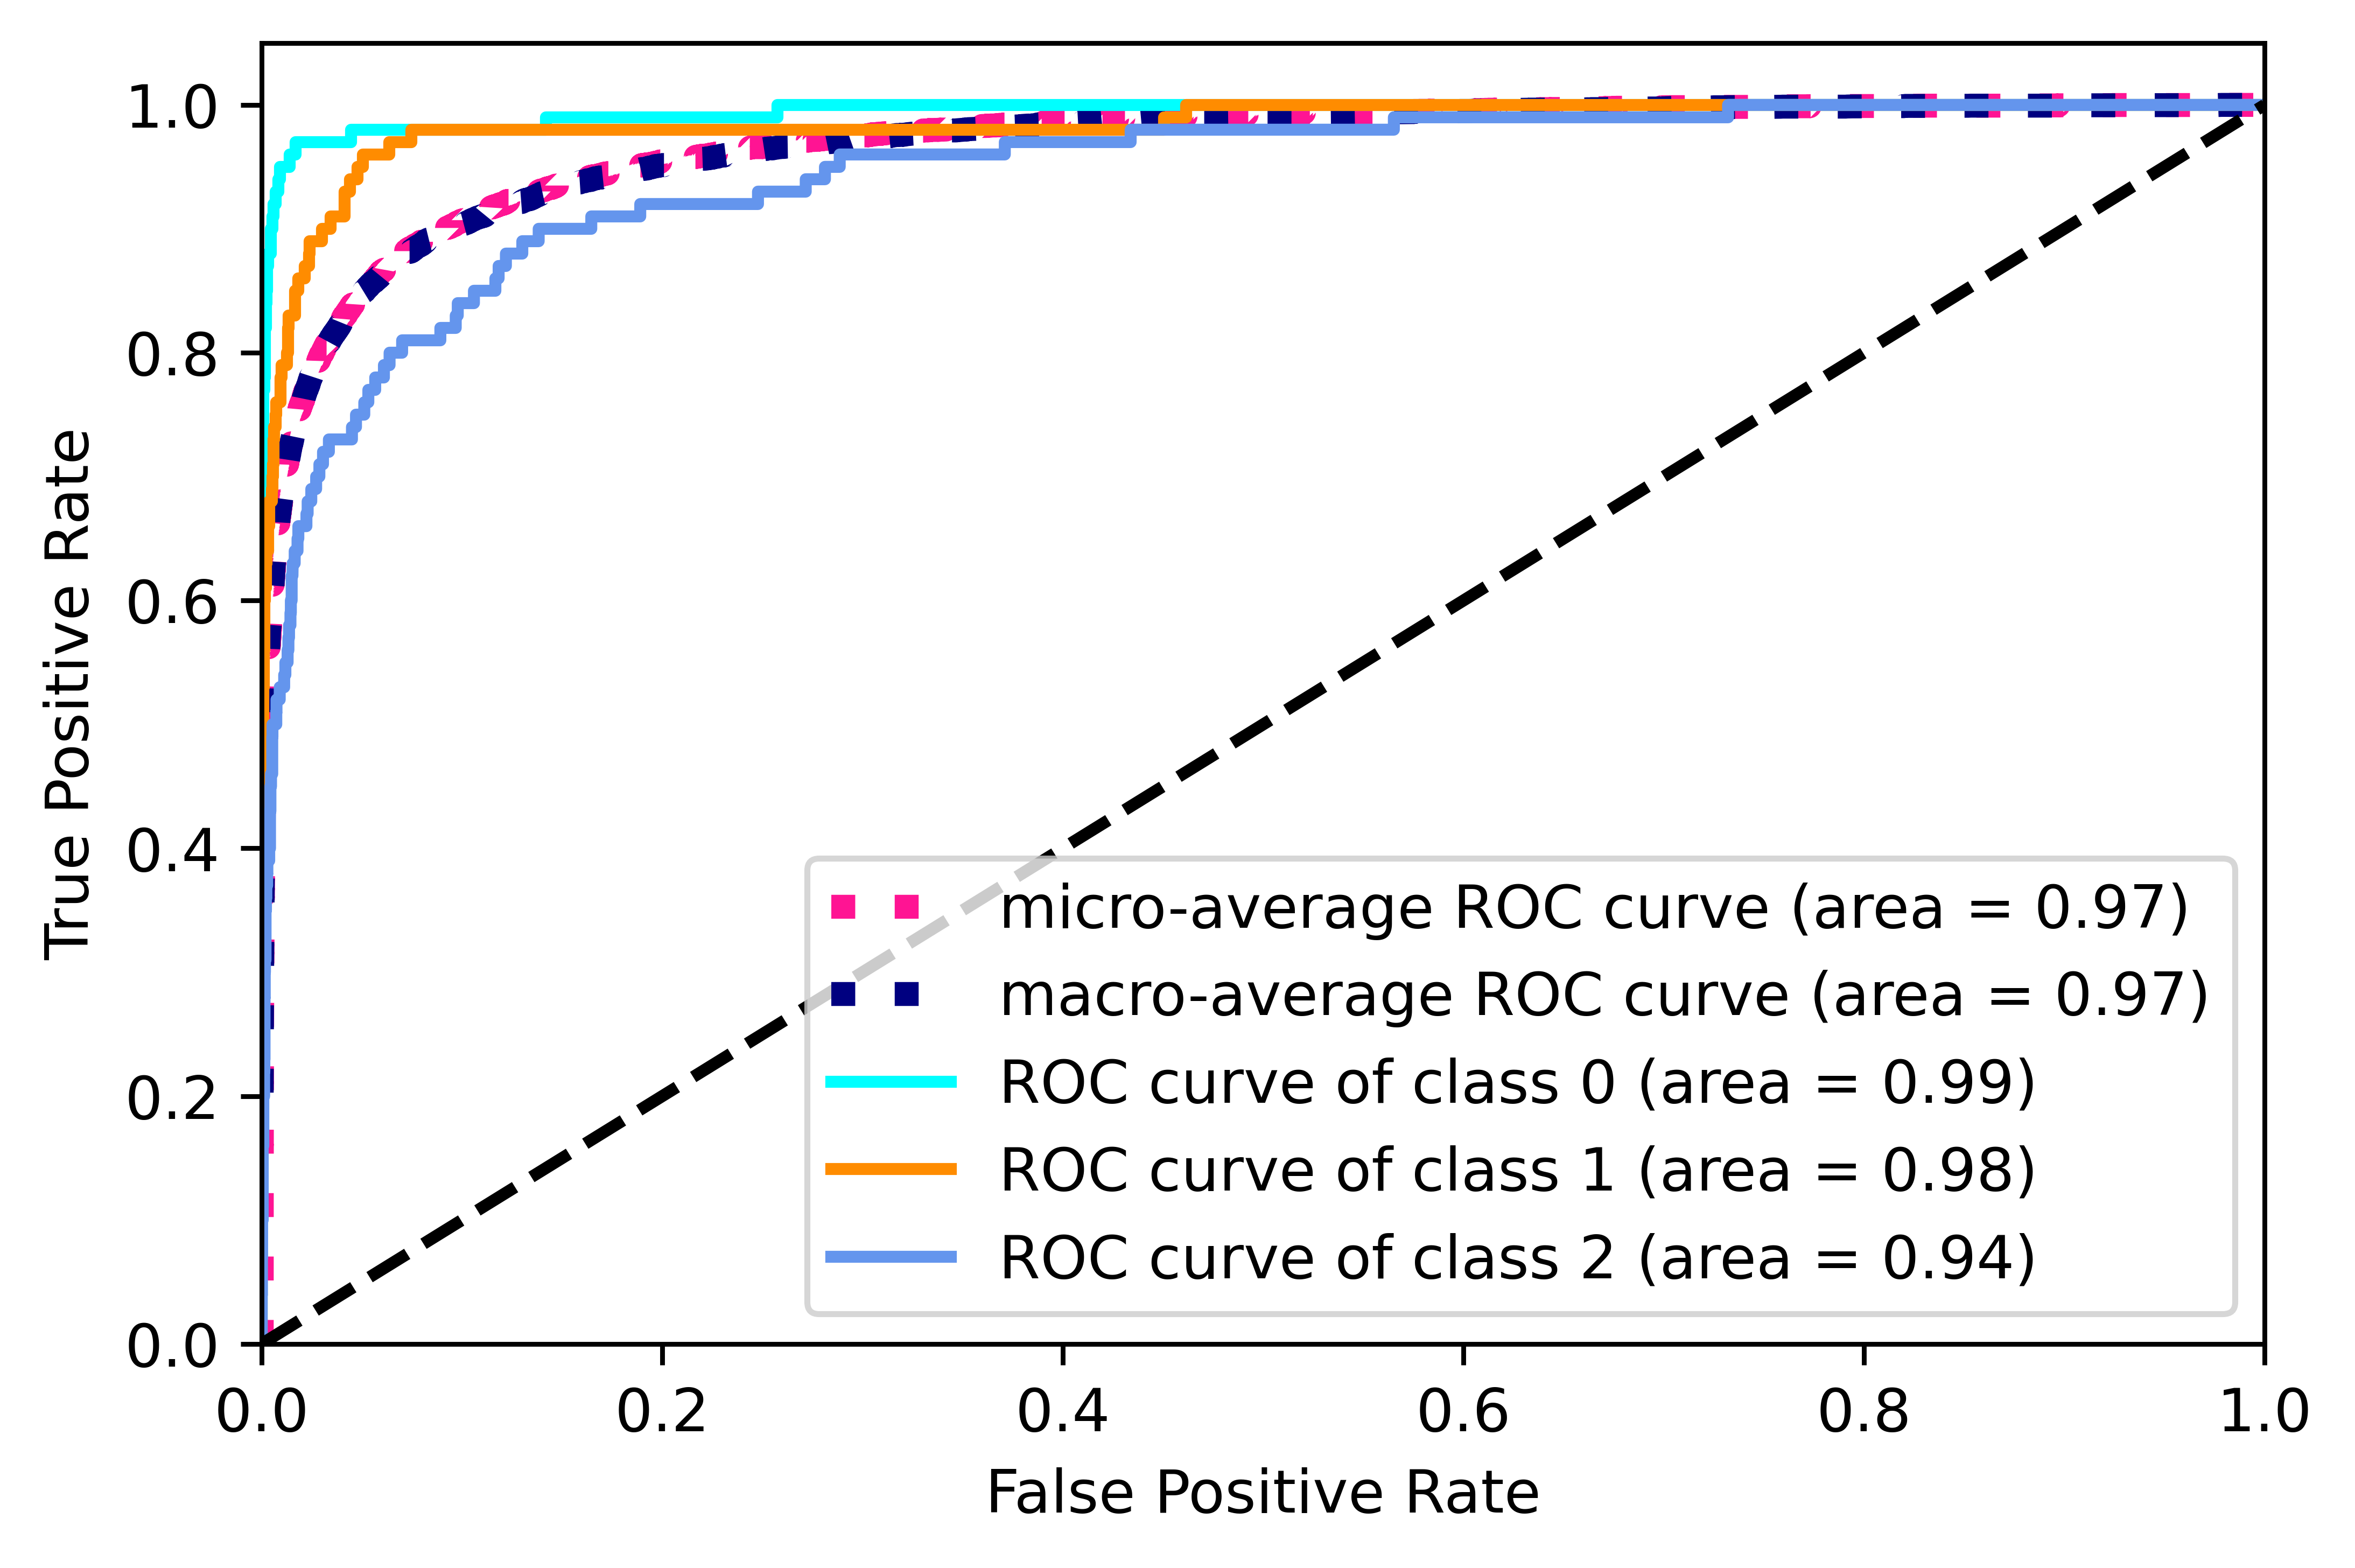

In [49]:
#import torch
#import torch.nn as nn
#import os
#import numpy as np
#from torchvision.datasets import ImageFolder
#from scipy import interp
#import matplotlib.pyplot as plt
#from itertools import cycle
#from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score


 
#os.environ['CUDA_VISIBLE_DEVICES'] = "0"
num_class = 100    # 类别数量

# mean=[0.948078, 0.93855226, 0.9332005], var=[0.14589554, 0.17054074, 0.18254866]
def test(model, cifar100_test):
    # 加载测试集和预训练模型参数
#    test_dir = os.path.join(data_root, 'test_images')
#    class_list = list(os.listdir(test_dir))
#    class_list.sort()
#    transform_test = get_transform_for_test(mean=[0.948078, 0.93855226, 0.9332005],
#                                            var=[0.14589554, 0.17054074, 0.18254866])#改
#    test_dataset = ImageFolder(test_dir, transform=transform_test)
    test_loader = torch.utils.data.DataLoader(cifar100_test, batch_size=1, shuffle=False, drop_last=False, pin_memory=True, num_workers=1)
    checkpoint = torch.load("59D.ckpt")
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
 
    score_list = []     # 存储预测得分
    label_list = []     # 存储真实标签
    for i, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.cuda()
        labels = labels.cuda()
 
        outputs = model(inputs)
        # prob_tmp = torch.nn.Softmax(dim=1)(outputs) # (batchsize, nclass)
        score_tmp = outputs  # (batchsize, nclass)
 
        score_list.extend(score_tmp.detach().cpu().numpy())
        label_list.extend(labels.cpu().numpy())
 
    score_array = np.array(score_list)
    # 将label转换成onehot形式
    label_tensor = torch.tensor(label_list)
    label_tensor = label_tensor.reshape((label_tensor.shape[0], 1))
    label_onehot = torch.zeros(label_tensor.shape[0], num_class)
    label_onehot.scatter_(dim=1, index=label_tensor, value=1)
    label_onehot = np.array(label_onehot)
 
    print("score_array:", score_array.shape)  # (batchsize, classnum)
    print("label_onehot:", label_onehot.shape)  # torch.Size([batchsize, classnum])
 
    # 调用sklearn库，计算每个类别对应的fpr和tpr
    fpr_dict = dict()
    tpr_dict = dict()
    roc_auc_dict = dict()
    for i in range(num_class):
        fpr_dict[i], tpr_dict[i], _ = roc_curve(label_onehot[:, i], score_array[:, i])
        roc_auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])
    # micro
    fpr_dict["micro"], tpr_dict["micro"], _ = roc_curve(label_onehot.ravel(), score_array.ravel())
    roc_auc_dict["micro"] = auc(fpr_dict["micro"], tpr_dict["micro"])
 
    # macro
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in range(num_class)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_class):
        mean_tpr += interp(all_fpr, fpr_dict[i], tpr_dict[i])
    # Finally average it and compute AUC
    mean_tpr /= num_class
    fpr_dict["macro"] = all_fpr
    tpr_dict["macro"] = mean_tpr
    roc_auc_dict["macro"] = auc(fpr_dict["macro"], tpr_dict["macro"])
 
    # 绘制所有类别平均的roc曲线
    plt.figure(dpi = 800)
    lw = 2
    plt.plot(fpr_dict["micro"], tpr_dict["micro"], label='micro-average ROC curve (area = {0:0.2f})' ''.format(roc_auc_dict["micro"]), color='deeppink', linestyle=':', linewidth=4)
    print("micro")
    plt.plot(fpr_dict["macro"], tpr_dict["macro"], label='macro-average ROC curve (area = {0:0.2f})' ''.format(roc_auc_dict["macro"]), color='navy', linestyle=':', linewidth=4)
    print("macro")
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(3), colors):
        plt.plot(fpr_dict[i], tpr_dict[i], color=color, lw=lw, label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc_dict[i]))
        print(i)
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.savefig('resnet18roc.jpg')
    plt.show()
 
 
if __name__ == '__main__':
    # 加载模型
    net = ResNet18()#改
    net = net.to(device)
    test(net, cifar100_test)

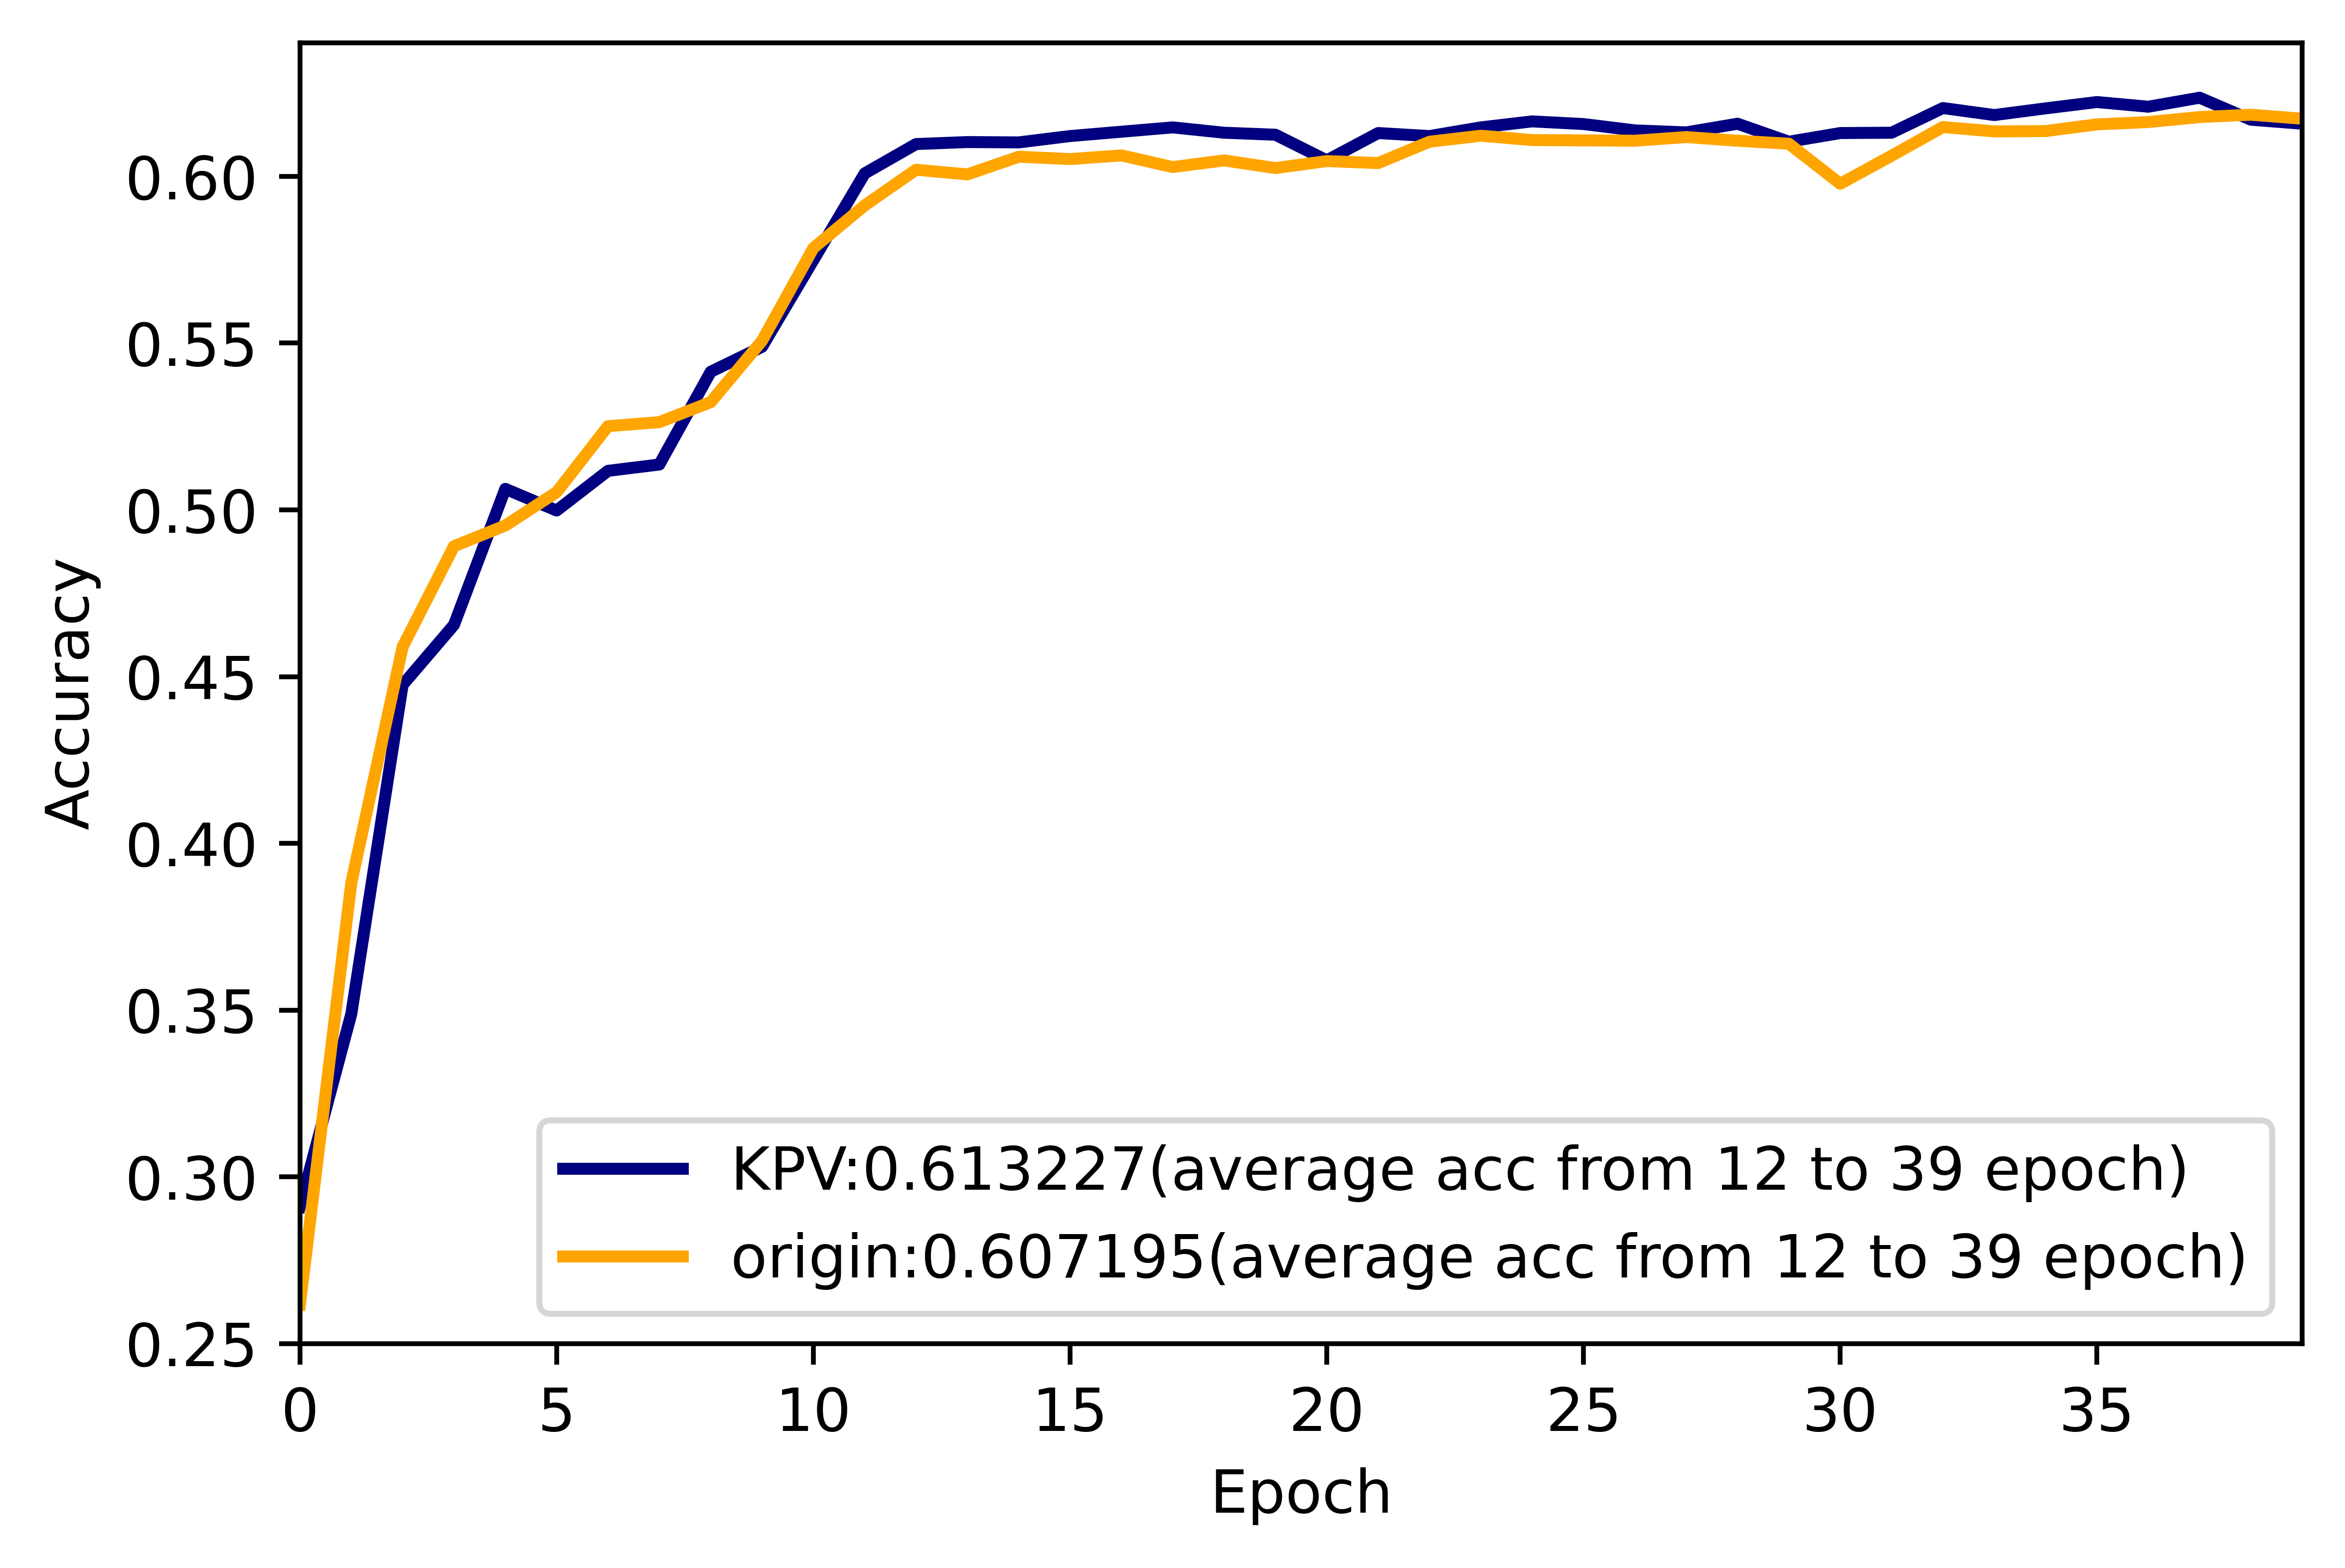

In [36]:
loss = [0.2911,0.3488,0.4475,0.4655,0.5063,0.4998,0.5117,0.5136,0.5414,0.5489,0.5749,0.6009,0.6097,0.6103,0.6102,0.6121,0.6134,0.6147,0.6131,0.6125,0.6048,0.613,0.6121,0.6147,0.6165,0.6157,0.6138,0.6132,0.6158,0.6104,0.613,0.6131,0.6205,0.6184,0.6204,0.6223,0.6209,0.6236,0.617,0.6158]
origin = [0.2617,0.3881,0.4589,0.4891,0.4953,0.5053,0.5251,0.5263,0.5323,0.5507,0.5785,0.5913,0.602,0.6006,0.6059,0.6052,0.6063,0.6028,0.6048,0.6025,0.6046,0.604,0.6104,0.6122,0.6109,0.6108,0.6107,0.6118,0.6107,0.6098,0.5978,0.6062,0.6148,0.6135,0.6136,0.6156,0.6163,0.6178,0.6185,0.6173]
plt.figure(dpi = 864)
#lw = 2
plt.plot(loss, label='KPV:0.613227(average acc from 12 to 39 epoch)', color='navy', linewidth=2)
plt.plot(origin, label='origin:0.607195(average acc from 12 to 39 epoch)', color='orange', linewidth=2)
#colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
#for i, color in zip(range(3), colors):
#    plt.plot(fpr_dict[i], tpr_dict[i], color=color, lw=lw, label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc_dict[i]))
#plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0, 39])
plt.ylim([0.25, 0.64])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc="lower right")
plt.savefig('resnet18acc.jpg')
plt.show()

In [ ]:
class Fconv(nn.Module):
    def __init__(self):
        super(Fconv, self).__init__()
        basic_kernel = [[0.1, 0.1, 0.1, 0.1, 0.1],
                        [0.1, 1.0, 1.0, 1.0, 0.1],
                        [0.1, 1.0, 1.0, 1.0, 0.1],
                        [0.1, 1.0, 1.0, 1.0, 0.1],
                        [0.1, 0.1, 0.1, 0.1, 0.1]]

        filter_3 = [[basic_kernel for p in range(3)] for q in range(3)]
        self.filter_3 = torch.tensor(filter_3, dtype=torch.float, device=device, requires_grad=False)
        self.bn_3 = nn.BatchNorm2d(3, device=device)

        filter_64 = [[basic_kernel for p in range(64)] for q in range(64)]
        self.filter_64 = torch.tensor(filter_64, dtype=torch.float, device=device, requires_grad=False)
        self.bn_64 = nn.BatchNorm2d(64, device=device)

        filter_128 = [[basic_kernel for p in range(128)] for q in range(128)]
        self.filter_128 = torch.tensor(filter_128, dtype=torch.float, device=device, requires_grad=False)
        self.bn_128 = nn.BatchNorm2d(128, device=device)

        filter_256 = [[basic_kernel for p in range(256)] for q in range(256)]
        self.filter_256 = torch.tensor(filter_256, dtype=torch.float, device=device, requires_grad=False)
        self.bn_256 = nn.BatchNorm2d(256, device=device)

        filter_512 = [[basic_kernel for p in range(512)] for q in range(512)]
        self.filter_512 = torch.tensor(filter_512, dtype=torch.float, device=device, requires_grad=False)
        self.bn_512 = nn.BatchNorm2d(512, device=device)

#        self.weight = nn.Parameter(data=kernel, requires_grad=False)
#        self.weight.to(device)
        
    def forward(self, x, ch):
        if ch == 3:
            x = F.conv2d(x, self.filter_3, padding=2, stride=1)
            x = F.relu(self.bn_3(x))
      
        if ch == 64:
            x = F.conv2d(x, self.filter_64, padding=2, stride=1)
            x = F.relu(self.bn_64(x))
      
        if ch == 128:
            x = F.conv2d(x, self.filter_128, padding=2, stride=1)
            x = F.relu(self.bn_128(x))
      
        if ch == 256:
            x = F.conv2d(x, self.filter_256, padding=2, stride=1)
            x = F.relu(self.bn_256(x))

        if ch == 512:
            x = F.conv2d(x, self.filter_512, padding=2, stride=1)
            x = F.relu(self.bn_512(x))

            

#        x = F.conv2d(x, self.weight, padding=2, stride=1)
#        x = F.relu(self.bn(x))
        return x
    
Fconv_ = Fconv()

In [ ]:
class KPVforResNet18():
    def __init__(self):
        self.basic_weight = [[0, 0, 0], [0, 1, 0], [0, 0, 0]]
        
        self.g_tensor_64x3 = [[self.basic_weight for p in range(3)] for q in range(64)]
        self.g_tensor_64x3 = torch.tensor(self.g_tensor_64x3, dtype=torch.float)#shape:[64x3x3x3]

        self.g_tensor_64x64, self.g_tensor_128x64, self.g_tensor_128x128, self.g_tensor_256x128
        self.g_tensor_256x256, self.g_tensor_512x256, self.g_tensor_512x512
        #creat Ai for every kinds of Ki
        
    def forward(self, net):
        custom_loss = 0
        num_conv = -1

        for param in net.parameters():
            num_conv = num_conv + 1
            
            param_ = param.to("cpu")#stransmit parameters from cuda to cpu
            if num_conv == 0:
                modify = param_ - self.g_tensor_64x3
            if num_conv == 3 or num_conv == 6 or num_conv == 9 or num_conv == 12:
                modify = param_ - self.g_tensor_64x64
            if num_conv == 15:
                modify = param_ - self.g_tensor_128x64
            if num_conv == 18 or num_conv == 24 or num_conv == 27:
                modify = param_ - self.g_tensor_128x128
            if num_conv == 30:
                modify = param_ - self.g_tensor_256x128
            if num_conv == 33 or num_conv == 39 or num_conv == 42:
                modify = param_ - self.g_tensor_256x256
            if num_conv == 45:
                modify = param_ - self.g_tensor_512x256
            if num_conv == 48 or num_conv == 54 or num_conv == 57:
                modify = param_ - self.g_tensor_512x512
            custom_loss += torch.sum(torch.norm(modify, p = 2).pow(2))
            #custom_loss = Σi(||Ki - Ai||^2)
        return custom_loss